# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import sys
sys.path.insert(0,'../../')

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
#save a slice
filename = 'jokes_dataset.csv'
raw_df = pd.read_csv('../data/'+filename, sep=',',
                encoding='utf-8').set_index('id')

# work with copy
df = raw_df.copy(deep=True)

# Preprocessing

In [5]:
from src import schema as S
from src.preprocessing.preprocessing import SimplePreprocessor
from bs4 import BeautifulSoup

preprocessor = SimplePreprocessor()

# Dataset augmenting

In [6]:
import nlpaug.augmenter.word as naw

aug_syn = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=1)

In [7]:
from src.augmenting.augmenting import Augmenter

augmenter = Augmenter(aug_syn)

# Dataset convertor

In [8]:
from src.text2seq.convertor import Text2SeqConvertor

convertor = Text2SeqConvertor()

# Model

Model can be imported from **src/models_full_joke/** or a new one can be written right here

In [9]:
# from src.models_full_joke.CNN_simple import CNNSimple

In [38]:
import torch.nn as nn
import src.schema as S

class AttentivePooling(nn.Module):
    def __init__(self, dim=-1, input_size=64, hidden_size=128):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nn_attn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return (x * torch.transpose(self.nn_attn(torch.transpose(x, 2, 1)), 1, 2).softmax(dim=self.dim)).sum(dim=self.dim)
    


class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens, hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
          nn.Conv1d(hid_size, hid_size*2, kernel_size=2),
          nn.Tanh(),
          nn.Conv1d(hid_size*2, hid_size*2, kernel_size=3),
          nn.LeakyReLU(),
          nn.Conv1d(hid_size*2, hid_size, kernel_size=5),
          nn.LeakyReLU(),
          nn.MaxPool1d(2),

          nn.Dropout(p=0.25),
          nn.LeakyReLU(),
          AttentivePooling(input_size=hid_size)
       )
      
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 5),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, batch):
        joke_embeddings = self.embedder(batch[S.JOKE]).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

# Pipeline

In [39]:
from src.pipeline.pipeline import Pipeline

pipeline = Pipeline(
                 preprocessor = preprocessor,
                 augmenter = None, # augmenter
                 convertor = convertor,
                 model = JokeRankPredictor, 
                 splitting_params = {'test_size': 0.2,
                                     'shuffle': True},
                 )


In [40]:
 %%time
train_df, val_df, test_df = pipeline.prepare_data(df)

DEBUG:pipeline-log:Starting preprocessing
DEBUG:pipeline-log:Splitting dataset on train, val and test
DEBUG:pipeline-log:Make vocabulary
DEBUG:pipeline-log:Split data to train/val/test after making vocabulary
Wall time: 2min 35s


In [41]:
train_df.shape, val_df.shape ,test_df.shape

((121635, 2), (30409, 2), (38012, 2))

# Train

In [33]:
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [34]:
iteration_list, loss_list, accuracy_list = pipeline.train_model(learning_rate,
                                                               criterion,
                                                               optimizer,
                                                               train_df,
                                                               val_df,
                                                               epochs=5,
                                                               checkpoint_path='../checkpoints/cnn_simple_best_checkpoint')

INFO:pipeline-log:Training model
INFO:pipeline-log:*** <class '__main__.JokeRankPredictor'>
Epoch 0


  0%|          | 0/950 [00:00<?, ?it/s]

Iteration: 99  Loss: 1.54897141456604  Accuracy: 34.522674560546875 %
Saving model and optimizer state at iteration 99 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 199  Loss: 1.540403962135315  Accuracy: 34.59830856323242 %
Saving model and optimizer state at iteration 199 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 299  Loss: 1.5693751573562622  Accuracy: 34.39113235473633 %
Iteration: 399  Loss: 1.5419002771377563  Accuracy: 34.57200241088867 %
Iteration: 499  Loss: 1.5161800384521484  Accuracy: 34.81534957885742 %
Saving model and optimizer state at iteration 499 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 599  Loss: 1.5337295532226562  Accuracy: 34.226707458496094 %
Iteration: 699  Loss: 1.5515328645706177  Accuracy: 34.588443756103516 %
Iteration: 799  Loss: 1.531928539276123  Accuracy: 34.68052291870117 %
Iteration: 899  Loss: 1.5106033086776733  Accuracy: 34.68052291870117 %
Epoch 1


  0%|          | 0/950 [00:00<?, ?it/s]

Iteration: 999  Loss: 1.5558781623840332  Accuracy: 34.871253967285156 %
Saving model and optimizer state at iteration 999 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 1099  Loss: 1.5342732667922974  Accuracy: 34.562137603759766 %
Iteration: 1199  Loss: 1.5475599765777588  Accuracy: 34.743003845214844 %
Iteration: 1299  Loss: 1.595454454421997  Accuracy: 35.00608444213867 %
Saving model and optimizer state at iteration 1299 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 1399  Loss: 1.5236021280288696  Accuracy: 33.92745590209961 %
Iteration: 1499  Loss: 1.5760031938552856  Accuracy: 34.95018005371094 %
Iteration: 1599  Loss: 1.5552538633346558  Accuracy: 34.844947814941406 %
Iteration: 1699  Loss: 1.5580495595932007  Accuracy: 34.996219635009766 %
Iteration: 1799  Loss: 1.5208584070205688  Accuracy: 30.319971084594727 %
Iteration: 1899  Loss: 1.5480163097381592  Accuracy: 34.86796569824219 %
Epoch 2


  0%|          | 0/950 [00:00<?, ?it/s]

Iteration: 1999  Loss: 1.5462796688079834  Accuracy: 35.03239059448242 %
Saving model and optimizer state at iteration 1999 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 2099  Loss: 1.5182158946990967  Accuracy: 35.170509338378906 %
Saving model and optimizer state at iteration 2099 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 2199  Loss: 1.5527266263961792  Accuracy: 35.15077590942383 %
Iteration: 2299  Loss: 1.5139997005462646  Accuracy: 33.73343276977539 %
Iteration: 2399  Loss: 1.5527645349502563  Accuracy: 35.091583251953125 %
Iteration: 2499  Loss: 1.4649230241775513  Accuracy: 32.57588195800781 %
Iteration: 2599  Loss: 1.5857337713241577  Accuracy: 35.03896713256836 %
Iteration: 2699  Loss: 1.5322682857513428  Accuracy: 35.170509338378906 %
Iteration: 2799  Loss: 1.546547293663025  Accuracy: 35.05541229248047 %
Epoch 3


  0%|          | 0/950 [00:00<?, ?it/s]

Iteration: 2899  Loss: 1.5656344890594482  Accuracy: 33.74658966064453 %
Iteration: 2999  Loss: 1.5592628717422485  Accuracy: 34.32207489013672 %
Iteration: 3099  Loss: 1.519184947013855  Accuracy: 33.894569396972656 %
Iteration: 3199  Loss: 1.5435174703598022  Accuracy: 34.848236083984375 %
Iteration: 3299  Loss: 1.5756170749664307  Accuracy: 33.871551513671875 %
Iteration: 3399  Loss: 1.5948196649551392  Accuracy: 35.01266098022461 %
Iteration: 3499  Loss: 1.5098309516906738  Accuracy: 33.351966857910156 %
Iteration: 3599  Loss: 1.5796667337417603  Accuracy: 34.57529067993164 %
Iteration: 3699  Loss: 1.5317972898483276  Accuracy: 34.239864349365234 %
Iteration: 3799  Loss: 1.5035734176635742  Accuracy: 34.09516906738281 %
Epoch 4


  0%|          | 0/950 [00:00<?, ?it/s]

Iteration: 3899  Loss: 1.53766930103302  Accuracy: 33.9669189453125 %
Iteration: 3999  Loss: 1.5337724685668945  Accuracy: 33.177677154541016 %
Iteration: 4099  Loss: 1.5087864398956299  Accuracy: 33.9669189453125 %
Iteration: 4199  Loss: 1.5094332695007324  Accuracy: 35.30204772949219 %
Saving model and optimizer state at iteration 4199 to ../checkpoints/cnn_simple_best_checkpoint
Iteration: 4299  Loss: 1.4968342781066895  Accuracy: 34.0261116027832 %
Iteration: 4399  Loss: 1.4934910535812378  Accuracy: 33.74658966064453 %
Iteration: 4499  Loss: 1.5265172719955444  Accuracy: 35.04883575439453 %
Iteration: 4599  Loss: 1.5041130781173706  Accuracy: 34.43388366699219 %
Iteration: 4699  Loss: 1.462034821510315  Accuracy: 33.77289581298828 %


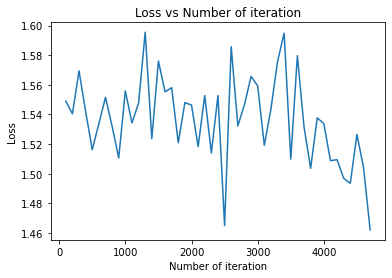

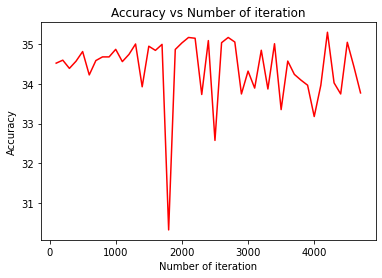

In [35]:
pipeline.draw_curves(iteration_list, loss_list, accuracy_list)

# Predict

In [36]:
pred = pipeline.predict(test_df, checkpoint_path='../checkpoints/cnn_simple_best_checkpoint')

INFO:pipeline-log:Starting prediction
Loading checkpoint '../checkpoints/cnn_simple_best_checkpoint'
Loaded checkpoint '../checkpoints/cnn_simple_best_checkpoint' from iteration 4199


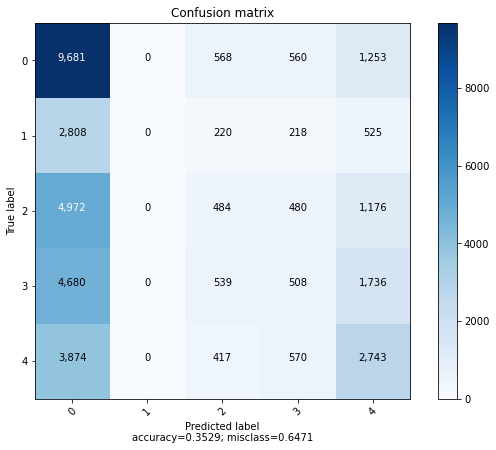

Accuracy: 0.35294 
Balanced accuracy: 0.25989 
Multiclass f1-score: 
    micro: 0.35294 
    macro: 0.21613 
    weighted: 0.27409


Classification report:

              precision    recall  f1-score   support

           0    0.37213   0.80260   0.50850     12062
           1    0.00000   0.00000   0.00000      3771
           2    0.21724   0.06805   0.10364      7112
           3    0.21747   0.06807   0.10368      7463
           4    0.36903   0.36073   0.36483      7604

    accuracy                        0.35294     38012
   macro avg    0.23517   0.25989   0.21613     38012
weighted avg    0.27525   0.35294   0.27409     38012



In [37]:
pipeline.get_scores(test_df[S.TARGET].values, pred)